In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
file_dir = os.path.join(os.getcwd(),'spatial-lstm','sensor_data','interpolated_data')
adcp = []
for i in range(1,5):
    file_name = 'ADCP_Sensor_'+str(i)+'.csv'
    file_path = os.path.join(file_dir,file_name)
    df = pd.read_csv(file_path, parse_dates=True, index_col="observed_timestamp")
    df[np.isnan(df)]=-1 # mask the missing values
    adcp.append(df['value'])
    print(df.index.min(),df.index.max()) # Check timestamp

2019-01-01 00:00:00 2019-12-31 23:30:00
2019-01-01 00:00:00 2019-12-31 23:30:00
2019-01-01 00:00:00 2019-12-31 23:30:00
2019-01-01 00:00:00 2019-12-31 23:30:00


In [3]:
df = pd.DataFrame(adcp).transpose()
df.head()

,value,value,value,value
observed_timestamp,,,,
2019-01-01 00:00:00,28.274415,9.636717,25.353515,19.801758
2019-01-01 00:30:00,27.239258,12.173828,30.364747,18.477539
2019-01-01 01:00:00,27.541013,12.520508,26.920409,19.249998
2019-01-01 01:30:00,29.662109,12.282225,31.734375,18.083008
2019-01-01 02:00:00,32.172850,13.845703,36.116213,17.734374


In [4]:
df.columns = ['ADCP_Sensor_1', 'ADCP_Sensor_2', 'ADCP_Sensor_3', 'ADCP_Sensor_4']

In [5]:
df.head()

,ADCP_Sensor_1,ADCP_Sensor_2,ADCP_Sensor_3,ADCP_Sensor_4
observed_timestamp,,,,
2019-01-01 00:00:00,28.274415,9.636717,25.353515,19.801758
2019-01-01 00:30:00,27.239258,12.173828,30.364747,18.477539
2019-01-01 01:00:00,27.541013,12.520508,26.920409,19.249998
2019-01-01 01:30:00,29.662109,12.282225,31.734375,18.083008
2019-01-01 02:00:00,32.172850,13.845703,36.116213,17.734374


<AxesSubplot:xlabel='observed_timestamp'>

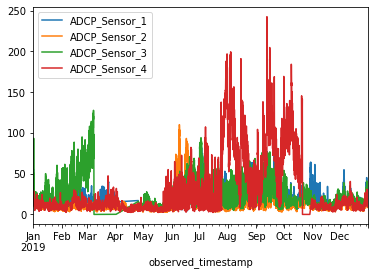

In [6]:
df.plot()

In [7]:
print(df.shape)

(17520, 4)


In [8]:
df = df.resample(rule='D').mean()
print(df.shape)

(365, 4)


<AxesSubplot:xlabel='observed_timestamp'>

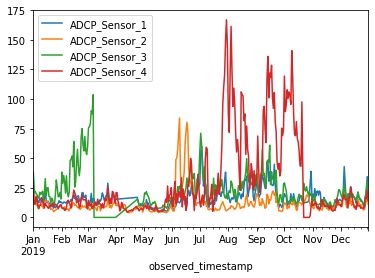

In [9]:
df.plot()

In [10]:
# Percentage of data for testing
test_percent = 0.1

# No. of test points
test_points= np.round(len(df)*test_percent)

# Test Cut off point (index value)
test_ind = int(len(df)-test_points)

print(test_percent, test_points, test_ind)

0.1 36.0 329


In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
print(train.shape, test.shape)
print(type(train), type(test))

(329, 4) (36, 4)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [14]:
print(scaled_train.shape, scaled_test.shape)
print(type(scaled_train), type(scaled_test))

(329, 4) (36, 4)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
# length of input sequence in number of timesteps (number of input samples to produce one output)
length = 36
# Number of timeseries samples in each batch
batch_size = 1
# No.of features
n_features = 4

generator = TimeseriesGenerator(data=scaled_train, 
                                targets=scaled_train, 
                                length=length, 
                                batch_size=batch_size)

In [17]:
print(len(scaled_train),len(generator))
len(scaled_train)-len(generator) # lenght given by us

329 293


36

In [18]:
X, y = generator[0]

In [19]:
print(X.shape, y.shape)

(1, 36, 4) (1, 4)


In [20]:
# (1, 36, 4) --> (batch_size, length, n_features)
# (1, 4) --> (1, n_features)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional

In [40]:
model = Sequential()
model.add(SimpleRNN(units=length, input_shape=(length,n_features))) # input_shape=(36,4)
model.add(Dense(units=4))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 36)                1476      
                                                                 
 dense_1 (Dense)             (None, 4)                 148       
                                                                 
Total params: 1,624
Trainable params: 1,624
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit_generator(generator, epochs=5)

Epoch 1/5


C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_4696\3367823435.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=5)


293/293 [==============================] - 1s 2ms/step - loss: 0.0388
Epoch 2/5
293/293 [==============================] - 1s 2ms/step - loss: 0.0167
Epoch 3/5
293/293 [==============================] - 1s 2ms/step - loss: 0.0125
Epoch 4/5
293/293 [==============================] - 1s 2ms/step - loss: 0.0108
Epoch 5/5
293/293 [==============================] - 1s 2ms/step - loss: 0.0097


<AxesSubplot:>

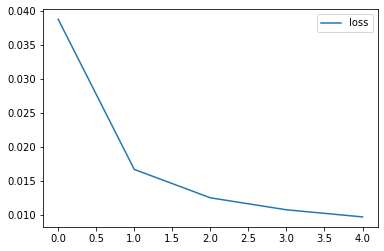

In [42]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [43]:
model.predict(current_batch)[0]

1/1 [==============================] - 0s 104ms/step


array([ 0.08078242,  0.02230618,  0.13532858, -0.00275698], dtype=float32)

In [39]:
current_batch[:,1:,:]

array([[[0.13135849, 0.13646419, 0.27666205, 0.        ],
        [0.13542186, 0.1177364 , 0.22955927, 0.        ],
        [0.13948523, 0.14251036, 0.21488521, 0.        ],
        [0.1435486 , 0.18573344, 0.25124536, 0.        ],
        [0.14761197, 0.17776276, 0.21615357, 0.        ],
        [0.15167534, 0.17066408, 0.18319936, 0.        ],
        [0.22360966, 0.12785917, 0.20902804, 0.        ],
        [0.43873414, 0.08380448, 0.17936671, 0.00871837],
        [0.61912861, 0.06748448, 0.19269407, 0.0570154 ],
        [0.18713024, 0.06356556, 0.1603106 , 0.08997361],
        [0.26611464, 0.05262813, 0.14491164, 0.05862518],
        [0.21664867, 0.04138329, 0.13366778, 0.0645275 ],
        [0.3526939 , 0.1328013 , 0.18287225, 0.06916959],
        [0.23541183, 0.09053884, 0.10316283, 0.07911057],
        [0.30447749, 0.06026861, 0.11024969, 0.0583111 ],
        [0.31653821, 0.04321044, 0.10533035, 0.0467339 ],
        [0.25200646, 0.03484313, 0.1005637 , 0.05425727],
        [0.316

In [44]:
test_pred = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 14ms/step


In [45]:
true_pred = scaler.inverse_transform(test_pred)

In [47]:
test[['RNN_1','RNN_2','RNN_3','RNN_4']] = true_pred
test.head()

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_4696\3932421098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['RNN_1','RNN_2','RNN_3','RNN_4']] = true_pred
C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_4696\3932421098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['RNN_1','RNN_2','RNN_3','RNN_4']] = true_pred
C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_4696\3932421098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,ADCP_Sensor_1,ADCP_Sensor_2,ADCP_Sensor_3,ADCP_Sensor_4,RNN_1,RNN_2,RNN_3,RNN_4
observed_timestamp,,,,,,,,
2019-11-26,8.363787,8.722875,12.293803,9.535591,9.347787,5.728847,14.027291,-0.460396
2019-11-27,10.128178,10.953424,15.686930,15.880819,9.455052,3.690821,15.575365,-2.881359
2019-11-28,11.324481,11.683136,18.693120,12.501556,8.015515,5.141662,12.724044,-1.628311
2019-11-29,14.326148,11.357078,23.465047,10.646911,7.243926,6.544384,10.561982,-2.527171
2019-11-30,15.320812,12.766372,23.041950,10.389649,4.834928,10.702599,9.372471,-0.061033


<AxesSubplot:xlabel='observed_timestamp'>

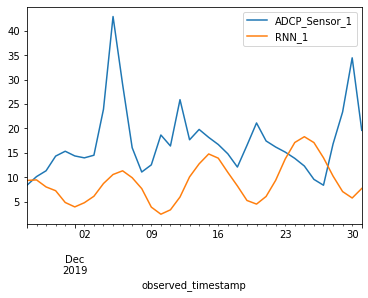

In [49]:

test.filter(regex='_1',axis=1).plot()

Text(0.5, 1.0, 'ADCP_Sensor_4')

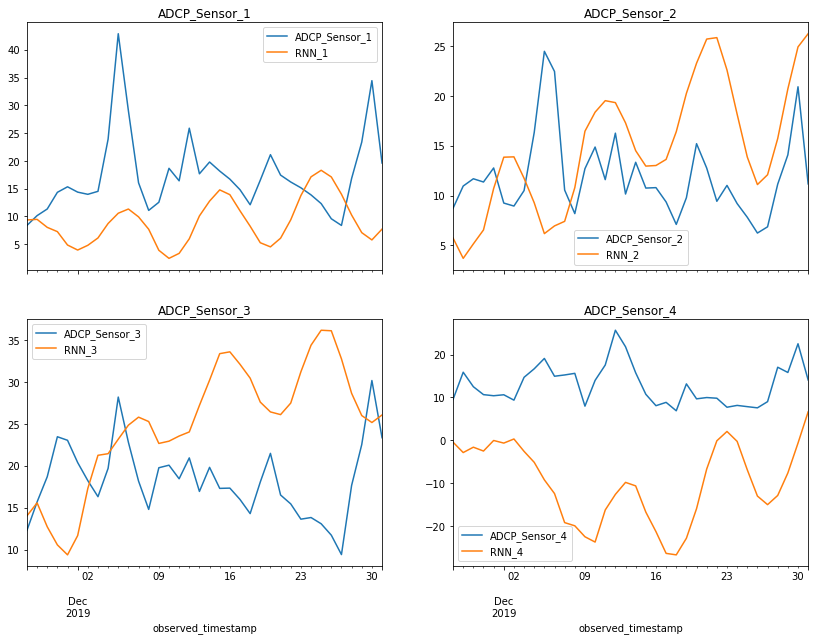

In [54]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(14,10))

test.filter(regex='_1',axis=1).plot(ax=axes[0,0])
axes[0,0].set_title('ADCP_Sensor_1')

test.filter(regex='_2',axis=1).plot(ax=axes[0,1])
axes[0,1].set_title('ADCP_Sensor_2')

test.filter(regex='_3',axis=1).plot(ax=axes[1,0])
axes[1,0].set_title('ADCP_Sensor_3')

test.filter(regex='_4',axis=1).plot(ax=axes[1,1])
axes[1,1].set_title('ADCP_Sensor_4')

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

In [56]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [57]:
# length of input sequence in number of timesteps (number of input samples to produce one output)
length = length-1
# Number of timeseries samples in each batch
batch_size = 1

generator = TimeseriesGenerator(data=scaled_train, 
                                targets=scaled_train, 
                                length=length, 
                                batch_size=batch_size)

val_generator = TimeseriesGenerator(data=scaled_test, targets=scaled_test, length=length, batch_size=1)

In [58]:
model = Sequential()
model.add(LSTM(units=length, input_shape=(length,n_features))) # input_shape=(35,4)
model.add(Dense(units=4))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 35)                5600      
                                                                 
 dense_2 (Dense)             (None, 4)                 144       
                                                                 
Total params: 5,744
Trainable params: 5,744
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.fit_generator(generator=generator, validation_data=val_generator, callbacks=[early_stop])

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_4696\3917464766.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=generator, validation_data=val_generator, callbacks=[early_stop])


294/294 [==============================] - 4s 7ms/step - loss: 0.0216 - val_loss: 8.8549e-04


In [60]:
test_pred = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 15ms/step


In [61]:
len(test_pred)

36

In [62]:
true_pred = scaler.inverse_transform(test_pred)

In [63]:
test[['LSTM_1','LSTM_2','LSTM_3','LSTM_4']] = true_pred
test.head()

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_4696\4007027690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['LSTM_1','LSTM_2','LSTM_3','LSTM_4']] = true_pred
C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_4696\4007027690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['LSTM_1','LSTM_2','LSTM_3','LSTM_4']] = true_pred
C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_4696\4007027690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,ADCP_Sensor_1,ADCP_Sensor_2,ADCP_Sensor_3,ADCP_Sensor_4,RNN_1,RNN_2,RNN_3,RNN_4,LSTM_1,LSTM_2,LSTM_3,LSTM_4
observed_timestamp,,,,,,,,,,,,
2019-11-26,8.363787,8.722875,12.293803,9.535591,9.347787,5.728847,14.027291,-0.460396,12.418368,8.741465,13.848369,11.631312
2019-11-27,10.128178,10.953424,15.686930,15.880819,9.455052,3.690821,15.575365,-2.881359,12.717769,9.056044,14.094723,12.667388
2019-11-28,11.324481,11.683136,18.693120,12.501556,8.015515,5.141662,12.724044,-1.628311,13.006478,9.348567,14.426185,13.604735
2019-11-29,14.326148,11.357078,23.465047,10.646911,7.243926,6.544384,10.561982,-2.527171,13.287056,9.619801,14.807313,14.483109
2019-11-30,15.320812,12.766372,23.041950,10.389649,4.834928,10.702599,9.372471,-0.061033,13.564184,9.869168,15.215086,15.321996


Text(0.5, 1.0, 'ADCP_Sensor_4')

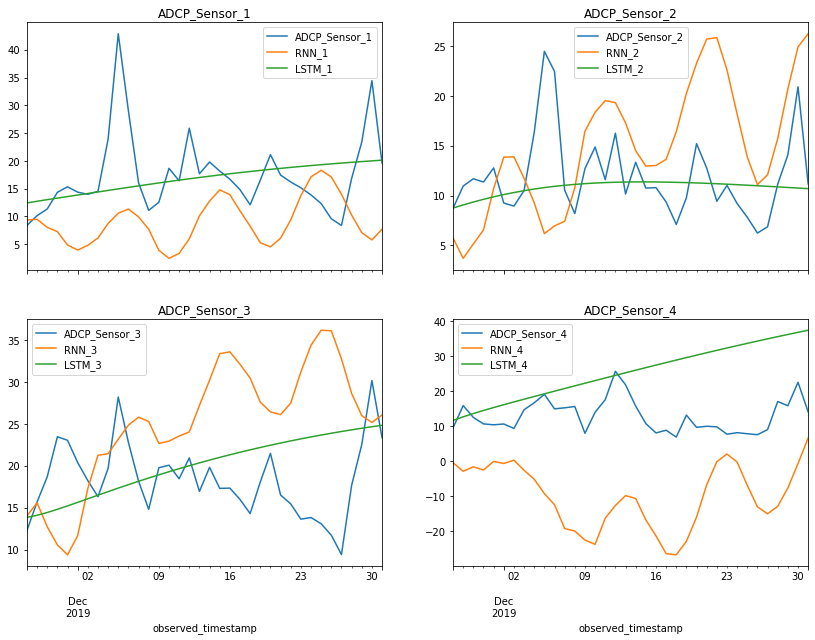

In [64]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(14,10))

test.filter(regex='_1',axis=1).plot(ax=axes[0,0])
axes[0,0].set_title('ADCP_Sensor_1')

test.filter(regex='_2',axis=1).plot(ax=axes[0,1])
axes[0,1].set_title('ADCP_Sensor_2')

test.filter(regex='_3',axis=1).plot(ax=axes[1,0])
axes[1,0].set_title('ADCP_Sensor_3')

test.filter(regex='_4',axis=1).plot(ax=axes[1,1])
axes[1,1].set_title('ADCP_Sensor_4')

In [66]:
# define stacked LSTM model
model_stacked = Sequential()
model_stacked.add(Bidirectional(LSTM(length, activation='relu'), input_shape=(length, n_features)))
model_stacked.add(Dense(n_features))
model_stacked.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 35)                5600      
                                                                 
 dense_2 (Dense)             (None, 4)                 144       
                                                                 
Total params: 5,744
Trainable params: 5,744
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.fit_generator(generator=generator, validation_data=val_generator, callbacks=[early_stop])

 21/294 [=>............................] - ETA: 1s - loss: 0.0103

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_4696\3917464766.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=generator, validation_data=val_generator, callbacks=[early_stop])


294/294 [==============================] - 2s 6ms/step - loss: 0.0146 - val_loss: 0.0025


In [68]:
test_pred = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 14ms/step


In [69]:
len(test_pred)

36

In [70]:
true_pred = scaler.inverse_transform(test_pred)

In [71]:
test[['BiLSTM_1','BiLSTM_2','BiLSTM_3','BiLSTM_4']] = true_pred
test.head()

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_4696\1982142649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['BiLSTM_1','BiLSTM_2','BiLSTM_3','BiLSTM_4']] = true_pred
C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_4696\1982142649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['BiLSTM_1','BiLSTM_2','BiLSTM_3','BiLSTM_4']] = true_pred
C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_4696\1982142649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,ADCP_Sensor_1,ADCP_Sensor_2,ADCP_Sensor_3,ADCP_Sensor_4,RNN_1,RNN_2,RNN_3,RNN_4,LSTM_1,LSTM_2,LSTM_3,LSTM_4,BiLSTM_1,BiLSTM_2,BiLSTM_3,BiLSTM_4
observed_timestamp,,,,,,,,,,,,,,,,
2019-11-26,8.363787,8.722875,12.293803,9.535591,9.347787,5.728847,14.027291,-0.460396,12.418368,8.741465,13.848369,11.631312,11.422793,12.010293,13.918453,12.041186
2019-11-27,10.128178,10.953424,15.686930,15.880819,9.455052,3.690821,15.575365,-2.881359,12.717769,9.056044,14.094723,12.667388,11.849805,12.753258,14.496923,13.098131
2019-11-28,11.324481,11.683136,18.693120,12.501556,8.015515,5.141662,12.724044,-1.628311,13.006478,9.348567,14.426185,13.604735,12.250757,13.578672,15.160410,14.240367
2019-11-29,14.326148,11.357078,23.465047,10.646911,7.243926,6.544384,10.561982,-2.527171,13.287056,9.619801,14.807313,14.483109,12.644688,14.449919,15.880106,15.451080
2019-11-30,15.320812,12.766372,23.041950,10.389649,4.834928,10.702599,9.372471,-0.061033,13.564184,9.869168,15.215086,15.321996,13.045266,15.344056,16.641551,16.708972


Text(0.5, 1.0, 'ADCP_Sensor_4')

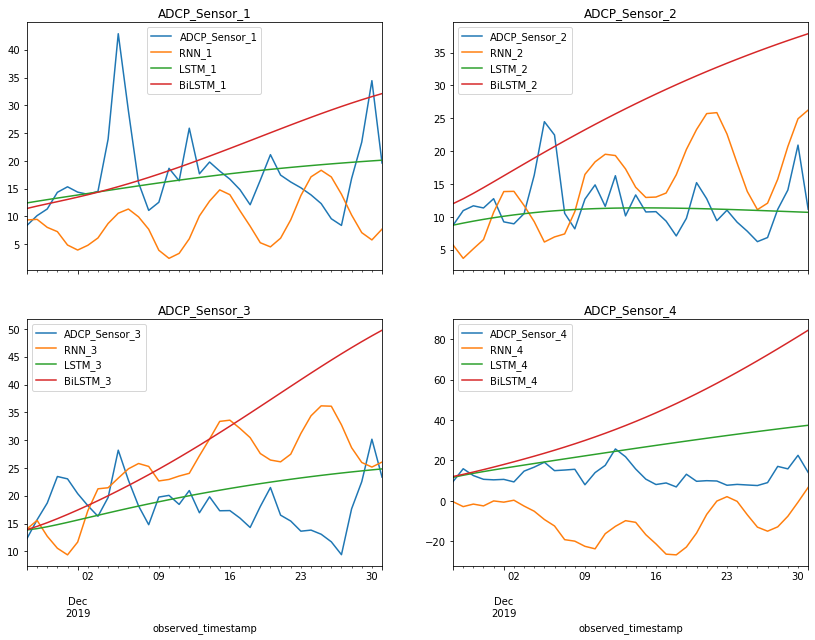

In [72]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(14,10))

test.filter(regex='_1',axis=1).plot(ax=axes[0,0])
axes[0,0].set_title('ADCP_Sensor_1')

test.filter(regex='_2',axis=1).plot(ax=axes[0,1])
axes[0,1].set_title('ADCP_Sensor_2')

test.filter(regex='_3',axis=1).plot(ax=axes[1,0])
axes[1,0].set_title('ADCP_Sensor_3')

test.filter(regex='_4',axis=1).plot(ax=axes[1,1])
axes[1,1].set_title('ADCP_Sensor_4')